In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
def load_data(filename):
    df = pd.read_csv(filename)
    dfOpen = np.array(df.Open)
    dfClose = np.array(df.Close)
    dfHigh = np.array(df.High)
    dfLow = np.array(df.Low)
    a = dfOpen.shape
    d = {}
    d['Open'] = dfOpen
    d['Close'] = dfClose
    d['High'] = dfHigh
    d['Low'] = dfLow
    return d

def calcMax(length, high):
    a = high.shape
    runningMax = np.zeros(a)
    runningMax[length-1] = max(high[:length])
    for i in range(length,a[0]):
        if high[i] >= runningMax[i-1]:
            runningMax[i] = high[i]
        elif runningMax[i-1] == high[i-length]:
            runningMax[i-1] = max(high[i-length+1:i+1])
        else:
            runningMax[i] = runningMax[i-1]
    return runningMax

def calcMin(length, low):
    a = low.shape
    runningLow = np.zeros(a)
    runningLow[length] = min(low[:length])
    for i in range(length,a[0]):
        if low[i] <= runningLow[i-1]:
            runningLow[i] = low[i]
        elif runningLow[i-1] == low[i-length]:
            runningLow[i] = min(low[i-length+1:i+1])
        else:
            runningLow[i] = runningLow[i-1]
    return runningLow

def calcSignal(length, rm, rl, high, low):
    a = rm.shape
    signal = np.zeros(a)
    for i in range(length,a[0]):
        if high[i] > rm[i-1]:
            if low[i] < rl[i-1]:
                signal[i] = 0
            else:
                signal[i] = 1
        elif low[i] < rl[i-1]:
            signal[i] = -1
    return signal

def calcDrawdown(portfolio):
    a = portfolio.shape
    drawdown = np.zeros(a)
    prevPeak = portfolio[0]
    for i in range(1,a[0]):
        if portfolio[i] < prevPeak:
            drawdown[i] = portfolio[i] - prevPeak
        elif portfolio[i] > prevPeak:
            prevPeak = portfolio[i]
    return drawdown

def calcTrades(length, stopPct, signal, close, Open):
    a = Open.shape
    trade = np.zeros(a)
    currentPos = 0.0
    prevPeak = 0.0
    prevTrough = 0.0
    for i in range(length+1,a[0]-1):
        if currentPos == 0:
            if signal[i-1] == 1: 
                trade[i] = 1
                currentPos = 1
                prevPeak = Open[i]
            elif signal[i-1] == -1:
                trade[i] = -1
                currentPos = -1
                prevPeak = prevTrough = Open[i]
        elif currentPos == 1:
            if close[i-1] > prevPeak:
                prevPeak = close[i-1]
            elif close[i-1] < (1-stopPct) * prevPeak:
                trade[i] = -1
                currentPos = 0
        elif currentPos == -1:
            if close[i-1] < prevTrough:
                prevTrough = close[i-1]
            elif close[i-1] > (1 + stopPct) * prevTrough:
                trade[i] = 1
                currentPos = 0
                
    if currentPos == 1:
        trade[a[0]-1] = -1
    elif currentPos == -1:
        trade[a[0]-1] = 1
    return trade

def calcPortfolio(length, stopPct, Open, high, low, close, capital):
    runningMax = calcMax(length, high)
    runningMin = calcMin(length, low)
    signal = calcSignal(length, runningMax, runningMin, high, low)
    trades = calcTrades(length, stopPct, signal, close, Open)
    a = Open.shape
    port = np.zeros(a)
    port[:length+1] = capital
    cash = capital
    contractSize = 1000
    currentPos = 0
    for i in range(length + 1, a[0]):
        if trades[i] == 1:
            currentPos += 1
            cash = cash - contractSize*Open[i]
        elif trades[i] == -1:
            currentPos -= 1
            cash = cash + contractSize*Open[i]
        port[i] = cash + currentPos*contractSize*Open[i]
    return port
            
    
        
    
    

In [4]:
dTY = load_data('TY-5min.csv')
dTU = load_data('TU-5min.csv')


In [8]:
stopPct = 0.5
timeStep = 10
capital = 10000.0
port = calcPortfolio(timeStep,stopPct,dTY['Open'],dTY['High'],dTY['Low'],dTY['Close'], capital)
drawdown = calcDrawdown(port)
max(port)

165812.5

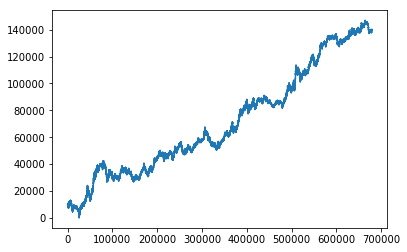

In [6]:
plt.plot(port)

In [89]:
rng = np.linspace(0.01,0.2,3)
rng2 = np.linspace(10,10000,10)
#rng3 = np.linspace(20000,100000,5)
#rng2 = np.append(rng2,rng3)
vals = np.zeros((3,10))
capital = 10000.0
count = 0
count1 = 0
for i in rng:
    for j in rng2:
        vals[count,count1] = max(calcPortfolio(int(j),i,dTY['Open'],dTY['High'],dTY['Low'],dTY['Close'], capital))
        count1 = count1 + 1
    print('Done')
    count1 = 0
    count = count + 1 
    

Done
Done
Done


In [90]:
vals

array([[ 166000.  ,  168281.25,  165031.25,  163937.5 ,  163937.5 ,
         163343.75,  168812.5 ,  166781.25,  168406.25,  168187.5 ],
       [ 166000.  ,  168281.25,  165031.25,  163937.5 ,  163937.5 ,
         163343.75,  168812.5 ,  166781.25,  168406.25,  168187.5 ],
       [ 166000.  ,  168281.25,  165031.25,  163937.5 ,  163937.5 ,
         163343.75,  168812.5 ,  166781.25,  168406.25,  168187.5 ]])

In [87]:
vals

array([[ 166000.  ,  168281.25,  165031.25,  163937.5 ,  163937.5 ,
         163343.75,  168812.5 ,  166781.25,  168406.25,  168187.5 ],
       [ 166000.  ,  168281.25,  165031.25,  163937.5 ,  163937.5 ,
         163343.75,  168812.5 ,  166781.25,  168406.25,  168187.5 ],
       [ 166000.  ,  168281.25,  165031.25,  163937.5 ,  163937.5 ,
         163343.75,  168812.5 ,  166781.25,  168406.25,  168187.5 ]])